In [1]:
import sys, os
from pyprojroot import here


# spyder up to find the root
# root = here(project_files=[".here"])
local = here(project_files=[".local"])

# append to path
# sys.path.append(str(root))
sys.path.append(str(local))

%load_ext autoreload
%autoreload 2

In [3]:
import xarray as xr
import numpy as np
import requests as rq
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from tqdm.notebook import tqdm, trange
from kernellib.types import GeoData, Dimensions
from kernellib.kernels import SpatioTemporalKernel
from kernellib.preprocessing import create_oi_grid
import hvplot.xarray

%load_ext autoreload
%autoreload 2
%load_ext memory_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [ ]:
!ls

In [39]:
file_path = "/Volumes/EMANS_HDD/data/2021a_ose/interim/OSE_ssh_mapping_BASELINE_test.nc"
# file_path = "/Volumes/EMANS_HDD/data/2021a_ose/interim/OSE_ssh_mapping_BASELINE_TRAIN_test.nc"

In [40]:
ds_oi = xr.open_dataset(file_path)

In [41]:
ds_oi.gssh_mu.hvplot.image(width=500, height=400, cmap="RdBu_r")

:DynamicMap   [time]
   :Image   [lon,lat]   (gssh_mu)

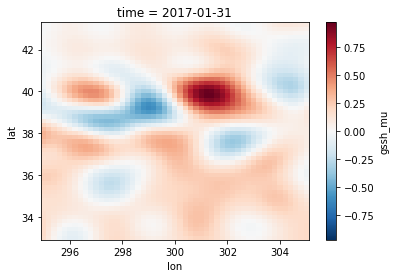

In [42]:
ds_oi.gssh_mu.isel(time=30).plot()

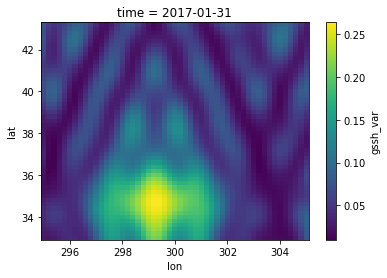

In [43]:
ds_oi.gssh_var.isel(time=30).plot()

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3628949912.py:3: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[0].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer, alpha=0.5)
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37391/3628949912.py:5: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[1].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")


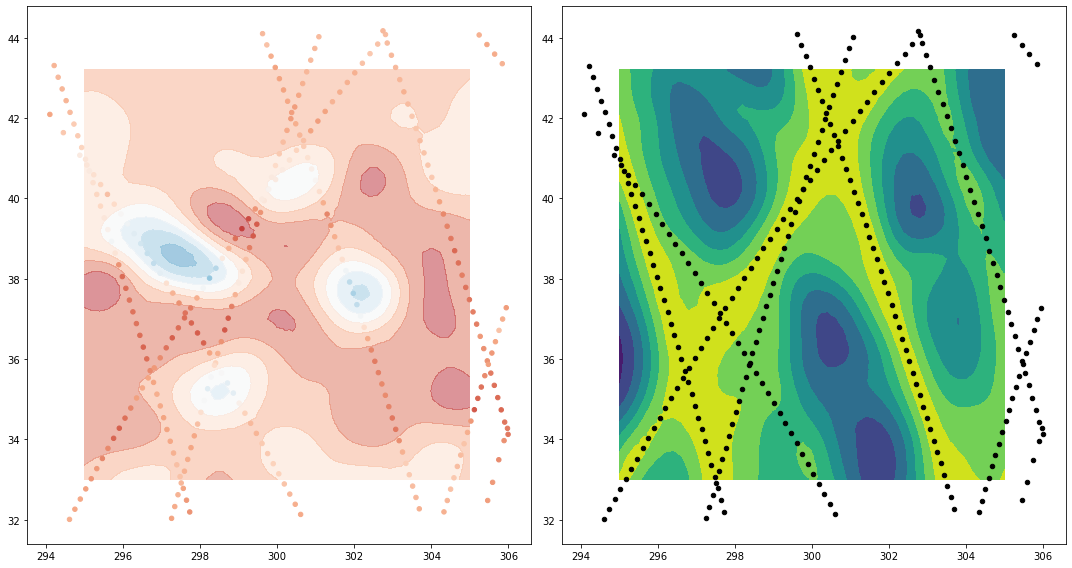

In [98]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 8))

ax[0].tricontourf(state_data.lon, state_data.lat, y_mu.squeeze(), cmap='RdBu_r', aspect="equal", vmin=vmin * buffer, vmax=vmax * buffer, alpha=0.5)
ax[0].scatter(obs_data_t.lon, obs_data_t.lat, s=20, c=obs_data_t.data, cmap="RdBu_r", vmin=vmin * buffer, vmax=vmax * buffer)
ax[1].tricontourf(state_data.lon, state_data.lat, y_std.squeeze(), cmap='viridis_r', aspect="equal")
ax[1].scatter(obs_data_t.lon, obs_data_t.lat, s=20, c='k', vmin=vmin * buffer, vmax=vmax * buffer)
# # plt.colorbar(img)
# # ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
# plt.xlabel('longitude', fontweight='bold')
# plt.ylabel('latitude', fontweight='bold')
# ax[0].set(title=f'Observations')
# ax[1].set(title=f'Interpolated (mean)')
# ax[2].set(title=f'Interpolated (variance)')
# # plt.colorbar(orientation='horizontal')
plt.tight_layout()
plt.show()

In [44]:
buffer = 1.05
vmin = ds_oi.gssh_samples.isel(time=30).min() * buffer
vmax = ds_oi.gssh_samples.isel(time=30).max() * buffer

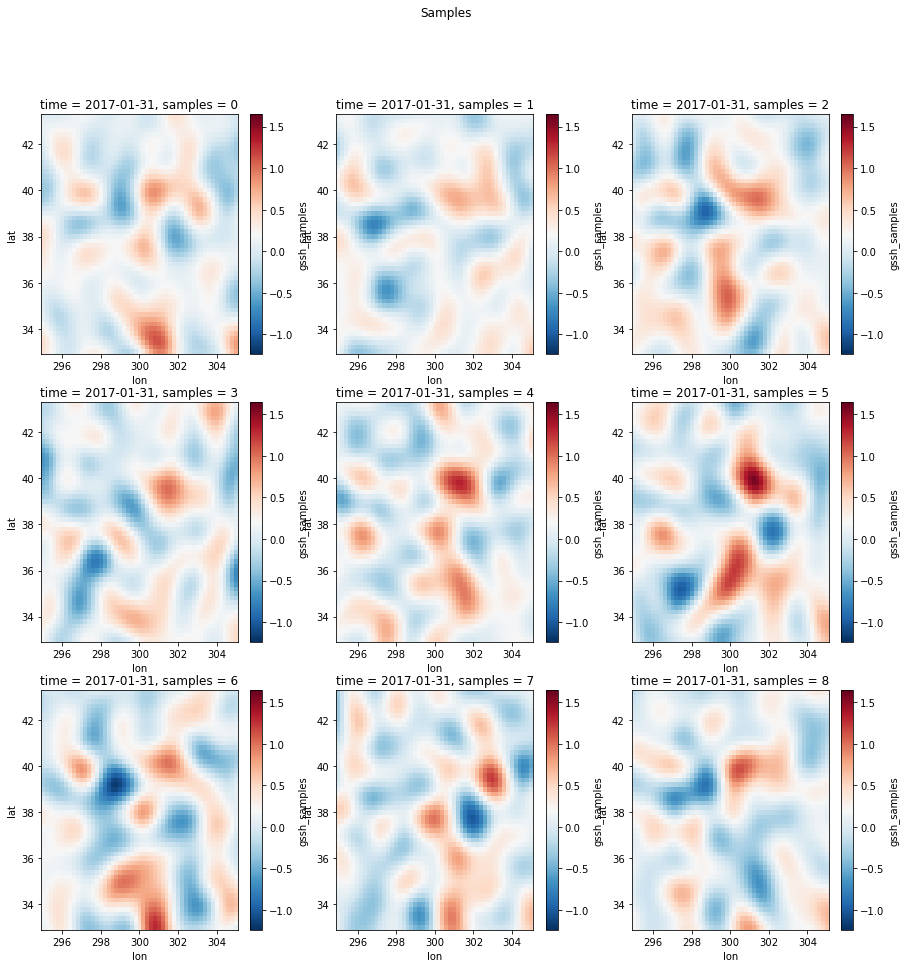

In [45]:
fig, axs = plt.subplots(figsize=(15, 15), nrows=3, ncols=3)

for i, iax in enumerate(axs.reshape(-1)[:5*5]):
    
    img = ds_oi.gssh_samples.isel(time=30, samples=i).plot.imshow(ax=iax, vmin=vmin, vmax=vmax, cmap="RdBu_r")
    # plt.colorbar(img)
    # ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
    # plt.xlabel('longitude', fontweight='bold')
    # plt.ylabel('latitude', fontweight='bold')
    # plt.colorbar(orientation='horizontal')
        
fig.suptitle("Samples")
plt.show()